# Setup

## Install dependencies

In [ ]:
%pip install python-dotenv -q
%pip install SPARQLWrapper -q
%pip install neo4j -q

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

## Connect to Neo4J

In [2]:
import os
from neo4j import GraphDatabase
from dotenv import load_dotenv

load_dotenv()
url = os.getenv('NEO4J_BOLT_URL')
user = os.getenv('NEO4J_USERNAME')
password = os.getenv('NEO4J_PASSWORD')

driver = GraphDatabase.driver(url, auth=(user,password))

# Populate database

## Purge

In [39]:
# Delete all nodes & relationships
with driver.session() as session:
    session.run("MATCH (n) DETACH DELETE n")

## Query religions

In [6]:
sparql.setQuery("""
SELECT DISTINCT ?subject ?subjectLabel
WHERE
{
{ ?subject wdt:P31 wd:Q9174 . } # instance_of religion
UNION
{ ?subject wdt:P31 wd:Q9134 . } # instance_of mythology

SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }

?subject rdfs:label ?subjectLabel .
FILTER(LANG(?subjectLabel) = "en") # Filter for English labels
}
""")

sparql.setReturnFormat(JSON)
religions = sparql.query().convert()

print(f"Found {len(religions['results']['bindings'])} religions")

Found 393 religions


## Query deities

In [7]:
sparql.setQuery("""
SELECT DISTINCT 
  ?deity ?deityLabel ?deityDescription
#   ?parentDeity ?parentDeityLabel 
  ?domainOfSaint ?domainOfSaintLabel 
  ?deityOf ?deityOfLabel
WHERE 
{
  { ?deity wdt:P31* wd:Q178885 . }     # instance_of deity
  UNION
  {
    ?deity wdt:P31 ?parentDeity .      # deities that are an instance of (P31) a parent deity
    ?parentDeity wdt:P279 wd:Q178885  .  # parent deity that is a "subclass of" (P279) 'deity' (Q178885)
  }

  ?deity p:P31 ?deity_instance .                  # instance_of (Pax is an instance of a Romain Deity)
  OPTIONAL { ?deity_instance pq:P642 ?deityOf . } # "of" attribute of the instance_of (Romain Deity OF peace) 
  OPTIONAL { ?deity wdt:P2925  ?domainOfSaint . } # "domain of saint or deity" (P2925) (Mars is deity of War and Agriculture)
  
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
    
  ?deity rdfs:label ?deityLabel .
  FILTER(LANG(?deityLabel) = "en")    # Filter for English labels
}
ORDER BY ?deityLabel
""")

sparql.setReturnFormat(JSON)
deities = sparql.query().convert()

print(f"Found {len(deities['results']['bindings'])} deities")

Found 3925 deities


In [4]:
sparql.setQuery("""
SELECT DISTINCT
  ?deity ?deityLabel
  ?deityOf ?deityOfLabel
  ?domainOfSaint ?domainOfSaintLabel

  ?partOf ?partOfLabel
  ?worshippedBy ?worshippedByLabel

  ?parentDeity ?parentDeityLabel
  ?parentPartOf ?parentPartOfLabel
  ?parentWorshippedBy ?parentWorshippedByLabel

WHERE
{
  ?deity wdt:P31 ?parentDeity .                              # deites that are an instance of (P31) a parent deity
  ?parentDeity wdt:P279 wd:Q178885 .                         # parent deity that is a "subclass of" (P279) 'deity' (Q178885)

  ?deity p:P31 ?deity_instance .                             # instance_of (Pax is an instance of a Romain Deity)

  OPTIONAL { ?deity_instance pq:P642 ?deityOf . }            # "of" attribute of the instance_of (Romain Deity OF peace)
  OPTIONAL { ?deity wdt:P2925 ?domainOfSaint . }             # "domain of saint or deity" (P2925) (Mars is deity of War and Agriculture)

  OPTIONAL { ?deity wdt:P361 ?partOf . }                     # deity is part of a religion or mythology
  OPTIONAL { ?deity wdt:P1049 ?worshippedBy . }              # deity is worshipped by of a religion or mythology
  OPTIONAL { ?parentDeity wdt:P361 ?parentPartOf . }         # 'part of' religion/mythology
  OPTIONAL { ?parentDeity wdt:P1049 ?parentWorshippedBy . }  # 'worshipped by' religion/mythology

  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
#   FILTER (BOUND(?deityOf))
  
  FILTER (BOUND(?partOf) || BOUND(?worshippedBy) || BOUND(?parentPartOf) || BOUND(?parentWorshippedBy))
  
  ?deity rdfs:label ?deityLabel .
  FILTER(LANG(?deityLabel) = "en")
}
ORDER BY ?deityLabel
# LIMIT 1000
""")

sparql.setReturnFormat(JSON)
deities = sparql.query().convert()

print(f"Found {len(deities['results']['bindings'])} deities")

Found 7080 deities


## Insert data

In [40]:
# insert religions
with driver.session() as session:  

  for row in religions["results"]["bindings"]:    
      session.run("""
                  MERGE (r:Religion { name: $name, entity: $entity })

                  """, 
        name=row["subjectLabel"]["value"], 
        entity=row["subject"]['value']
      )

In [41]:
with driver.session() as session:  

    for row in deities["results"]["bindings"]:
        query = "MERGE (d:Deity { name: $deity_name, entity: $deity})"
      
        params = {
            "deity_name": row["deityLabel"]["value"],
            "deity": row["deity"]["value"],
        }

      
        if ("domainOfSaintLabel" in row):
            query += """
            MERGE (domainOfSaint:Domain { name: $domain_name, entity: $domain }) 
            MERGE (d)-[:GOD_OF]->(domainOfSaint)"""
          
            params["domain_name"]=row["domainOfSaintLabel"]["value"]
            params["domain"]=row["domainOfSaint"]['value']

      
        if ("deityOf" in row):
            query += """
            MERGE (domain:Domain { name: $deityOf_name, entity: $deityOf }) 
            MERGE (d)-[:GOD_OF]->(domain)"""
            
            params["deityOf_name"]=row["deityOfLabel"]["value"]
            params["deityOf"]=row["deityOf"]['value']
        
        religion = None
        religion_name = None
        if ("worshippedBy" in row):            
            religion = row["worshippedBy"]['value']
            religion_name = row["worshippedByLabel"]["value"]               
        elif("partOf" in row):
            religion = row["partOf"]['value']
            religion_name = row["partOfLabel"]["value"]
        elif("parentWorshippedBy" in row):
            religion = row["parentWorshippedBy"]['value']
            religion_name = row["parentWorshippedByLabel"]["value"]
        elif("parentPartOf" in row):
            religion = row["parentPartOf"]['value']
            religion_name = row["parentPartOfLabel"]["value"]
    
        if religion and religion_name:
            query += """
                MERGE (r:Religion { name: $religion_name, entity: $religion }) 
                MERGE (d)-[:PART_OF]->(r)"""
                
            params["religion"] = religion
            params["religion_name"] = religion_name
    
        session.run(query, params)
      


In [25]:
# with driver.session() as session:  

#   for row in deities["results"]["bindings"]:    
#       session.run("""
#                   MERGE (d:Deity { name: $deity_name, entity: $deity_entity})
#                   """, 
#         deity_name=row["deityLabel"]["value"], 
#         deity_entity=row["deity"]['value'],
#         # deity_description=row.get("deityDescription", {}).get('value', '-')
#       )
      
#       if ("domainOfSaintLabel" in row):
#         session.run("""
#           MERGE (deity:Deity { entity: $deity_entity })
#           MERGE (domain:Domain { name: $domain_name, entity: $domain_entity }) 
#           MERGE (deity)-[:GOD_OF]->(domain)""", 
#           deity_entity=row["deity"]['value'],
#           domain_name=row["domainOfSaintLabel"]["value"], 
#           domain_entity=row["domainOfSaint"]['value']
#         )
      
#       if ("deityOf" in row):
#         session.run("""
#           MERGE (deity:Deity { entity: $deity_entity })
#           MERGE (domain:Domain { name: $domain_name, entity: $domain_entity }) 
#           MERGE (deity)-[:GOD_OF]->(domain)""", 
#           deity_entity=row["deity"]['value'],
#           domain_name=row["deityOfLabel"]["value"], 
#           domain_entity=row["deityOf"]['value']
#         )    
      
#       if ("worshippedBy" in row):
#         session.run("""
#           MERGE (deity:Deity { entity: $deity_entity })
#           MERGE (r:Religion { name: $religion_name, entity: $religion_entity }) 
#           MERGE (deity)-[:PART_OF]->(r)""",
#           deity_entity=row["deity"]['value'],
#           religion_name=row["worshippedByLabel"]["value"], 
#           religion_entity=row["worshippedBy"]['value']
#         )


In [8]:
# with driver.session() as session:  

#   for row in deities["results"]["bindings"]:    
#       session.run("""
#                   MERGE (d:Deity { name: $deity_name, entity: $deity_entity, description: $deity_description })

#                   """, 
#         deity_name=row["deityLabel"]["value"], 
#         deity_entity=row["deity"]['value'],
#         deity_description=row.get("deityDescription", {}).get('value', '-')
#       )
      
#       if ("domainOfSaintLabel" in row):
#           session.run("""
#               MERGE (deity:Deity { entity: $deity_entity })
#               MERGE (domain:Domain { name: $domain_name, entity: $domain_entity }) 
#               MERGE (deity)-[:GOD_OF]->(domain)
#               """, 
#                   domain_name=row["domainOfSaintLabel"]["value"], 
#                   domain_entity=row["domainOfSaint"]['value'],
#                   deity_entity=row["deity"]['value'])

# Query graph

In [ ]:
%pip install networkx matplotlib -q

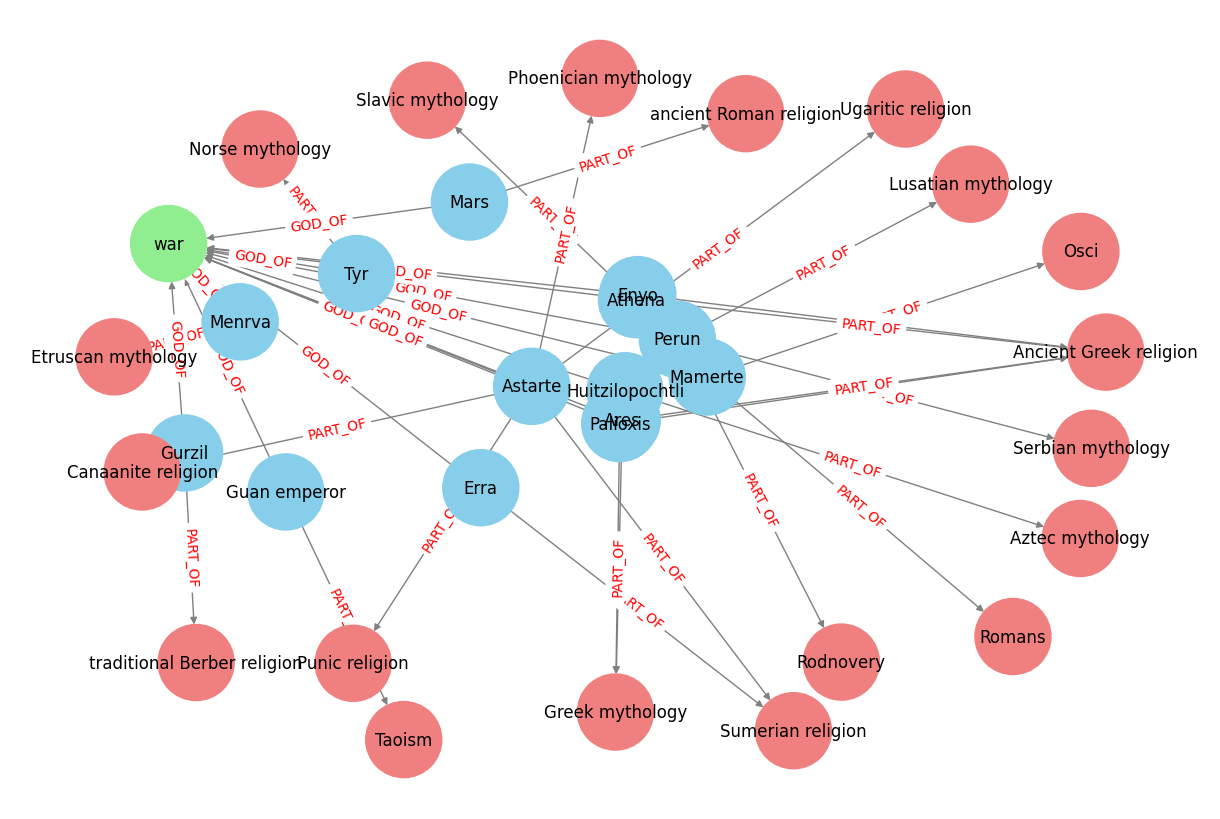

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

def fetch_data(tx):
    query = """
        MATCH(d:Deity)-[god_of:GOD_OF]-(domain:Domain)
        MATCH (d)-[part_of:PART_OF]-(r:Religion)
        WHERE domain.name = 'war'
        RETURN d, domain, r, god_of, part_of
    """
    return list(tx.run(query))


with driver.session() as session: 
    result = session.execute_read(fetch_data)

    G = nx.DiGraph()

    for record in result:
        diety = record["d"]
        domain = record["domain"]
        religion = record["r"]
        god_of = record["god_of"]
        part_of = record["part_of"]
        G.add_node(diety.element_id, label=diety["name"], type=list(diety.labels)[0])
        G.add_node(domain.element_id, label=domain["name"], type=list(domain.labels)[0])
        G.add_node(religion.element_id, label=religion["name"], type=list(religion.labels)[0])
        
        G.add_edge(diety.element_id, domain.element_id, label=god_of.type)    
        G.add_edge(diety.element_id, religion.element_id, label=part_of.type)
        
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')
    node_types = nx.get_node_attributes(G, 'type')
                
    color_map = {
        'Deity': 'skyblue',
        'Domain': 'lightgreen',
        'Religion': 'lightcoral'
    }

    node_colors = [color_map[types] for _, types in node_types.items()]


    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color=node_colors, font_size=12, font_color="black", font_weight="normal", edge_color="gray")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.show()

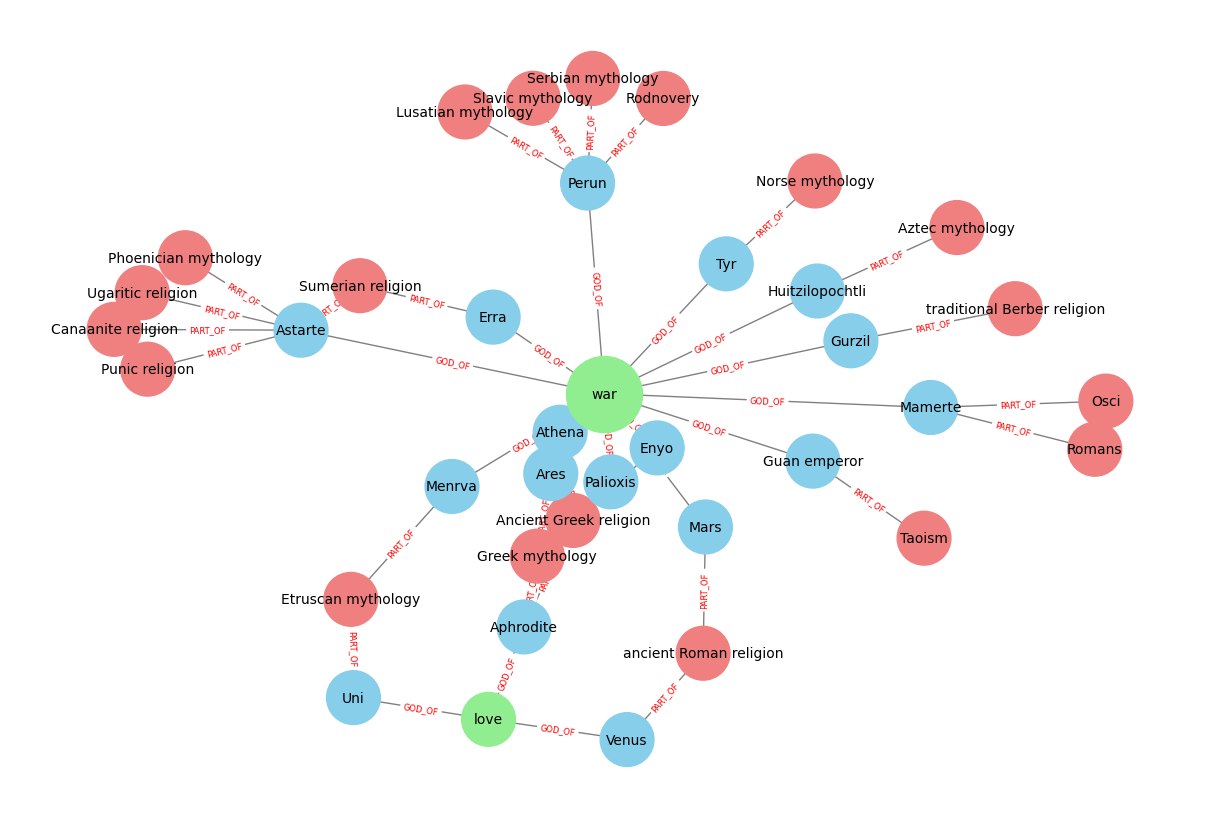

In [78]:
import networkx as nx
import matplotlib.pyplot as plt

def fetch_data(tx):
    query = """
        MATCH(d:Deity)-[god_of:GOD_OF]-(domain:Domain)
        MATCH (d)-[part_of:PART_OF]-(r:Religion)
        WHERE domain.name IN ['war', 'love']
        RETURN d, domain, r, god_of, part_of
    """
    return list(tx.run(query))


with driver.session() as session: 
    result = session.execute_read(fetch_data)

    nodes = set()
    edges = []

    G = nx.Graph()

    for record in result:
        diety = record["d"]
        domain = record["domain"]
        religion = record["r"]
        god_of = record["god_of"]
        part_of = record["part_of"]
        G.add_node(diety.element_id, label=diety["name"], type=list(diety.labels)[0])
        G.add_node(domain.element_id, label=domain["name"], type=list(domain.labels)[0])
        G.add_node(religion.element_id, label=religion["name"], type=list(religion.labels)[0])
        
        G.add_edge(diety.element_id, domain.element_id, label=god_of.type)    
        G.add_edge(diety.element_id, religion.element_id, label=part_of.type)
        

    # Identify the node with the most edges
    central_node = max(G.degree, key=lambda x: x[1])[0]

    pos = nx.spring_layout(G, k=0.1, iterations=50)
    pos[central_node] = [0, 0]

    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')
    node_types = nx.get_node_attributes(G, 'type')


    color_map = {
        'Deity': 'skyblue',
        'Domain': 'lightgreen',
        'Religion': 'lightcoral'
    }

    node_colors = [color_map[types] for _, types in node_types.items()]


    plt.figure(figsize=(12, 8))

    # Draw the graph with the central node in the middle
    nx.draw(G, pos, labels=labels, with_labels=True,  node_color=node_colors, edge_color='gray', node_size=1500, font_size=10)

    # Highlight the central node
    nx.draw_networkx_nodes(G, pos, nodelist=[central_node], node_color=color_map['Domain'], node_size=3000)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=6)

    plt.show()